## Recreating the following for classification problem
https://www.tensorflow.org/text/tutorials/transformer

Need tensorflow-text for using the BERT model tokenizer

In [2]:
# Install the nightly version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q -U tensorflow-text tensorflow

     |████████████████████████████████| 5.9 MB 25.9 MB/s 
     |████████████████████████████████| 578.0 MB 16 kB/s 
     |████████████████████████████████| 5.9 MB 51.8 MB/s 
     |████████████████████████████████| 438 kB 50.8 MB/s 
     |████████████████████████████████| 1.7 MB 50.1 MB/s 


Import the necessary modules:

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_text
from sklearn.utils import shuffle 

Doing necessary data preprocessing

In [5]:
os.listdir('.')

['.config', 'twitter_validation.csv', 'twitter_training.csv', 'sample_data']

In [6]:
training_data_loc = "./twitter_training.csv"
val_data_loc = "./twitter_validation.csv"

In [51]:
df = pd.read_csv(training_data_loc, names=["not_needed_1", "not_needed_2", "sentiment", "sentence"])
df

,not_needed_1,not_needed_2,sentiment,sentence
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [52]:
df.drop(["not_needed_1", "not_needed_2"], inplace=True, axis=1)

In [53]:
df

,sentiment,sentence
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
74677,Positive,Just realized that the Windows partition of my...
74678,Positive,Just realized that my Mac window partition is ...
74679,Positive,Just realized the windows partition of my Mac ...
74680,Positive,Just realized between the windows partition of...


In [54]:
df['sentiment'].value_counts()

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: sentiment, dtype: int64

In [55]:
df = df[df.apply(lambda x: (x["sentiment"] == "Positive") or (x["sentiment"] == "Negative"), axis=1)]

In [56]:
df['sentiment'].value_counts()

Negative    22542
Positive    20832
Name: sentiment, dtype: int64

In [57]:
def index_helper(x):
  if x == "Positive":
    return 1
  # if x == "Neutral":
  #   return 1
  return 0

In [58]:
df['sentiment'] = df['sentiment'].apply(lambda x: index_helper(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [59]:
df = shuffle(df)

df

,sentiment,sentence
12315,0,@NBA2K I brought 15 worth of checks it’s not s...
72688,0,A leading company that has the ability of to p...
56933,1,Welcome back this amazing community..
42302,0,@ PUBG hi I'm facing a in game problem where m...
6735,0,"Ugh, y’all fucking freak hoes! They sold out o..."
...,...,...
15613,0,Goosebumps is the most important thing in the ...
17974,1,Who can mama I gotta fuck up to get me the PS5
22854,0,Im actually so fucking annoyed with csgo. I pr...
25911,1,A refreshing remake of Assassin's Creed 1 ift....


In [60]:
df.isna().value_counts()

sentiment  sentence
False      False       43013
           True          361
dtype: int64

In [61]:
df.dropna(inplace=True) # dropping empty sentences

In [62]:
df.to_csv("preprocessed_training_data.csv")

In [63]:
labels = df['sentiment']
features = df['sentence']

## Tokenizer
using subword tokenizer implementation from Bert model

In [24]:
model_name = 'ted_hrlr_translate_pt_en_converter'

In [25]:
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [26]:
tokenizers = tf.saved_model.load(model_name)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. We just need the English one

# **Tokenizer**
Cannot prepare batches as required. I don't know how to fix it.

In [78]:
MAX_TOKENS=32
def prepare_batch(en): # not actually preparing batches
    en = tokenizers.en.tokenize(en)
    en = en[:, :MAX_TOKENS]
    return en

In [79]:
tokenized_sentences = prepare_batch(features) # batch_size, 64

In [80]:
new_features = tokenized_sentences.to_tensor()
new_features

<tf.Tensor: shape=(43013, 32), dtype=int64, numpy=
array([[   2,   31,   50, ...,    3,    0,    0],
       [   2,   37, 1746, ..., 5939, 2782, 2320],
       [   2, 2415,  193, ...,    0,    0,    0],
       ...,
       [   2,   45,  504, ...,  170,   15,   45],
       [   2,   37,  105, ...,  240, 1122,    3],
       [   2,  245,  438, ...,    0,    0,    0]])>

## Copied code 
we need to change it up a bit so we can use same definitions for our own classification problem

In [77]:
# needed constants
seq_len = 32

### Define the Embedding and Positional encoding

In [31]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

In [82]:
temp_encoding = positional_encoding(length=64, depth=256)
temp_encoding

<tf.Tensor: shape=(64, 256), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.84147096,  0.8019618 ,  0.7617204 , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.9092974 ,  0.95814437,  0.98704624, ...,  0.99999994,
         1.        ,  1.        ],
       ...,
       [-0.9661178 ,  0.21454576,  0.5507407 , ...,  0.99997133,
         0.9999752 ,  0.99997854],
       [-0.7391807 ,  0.9114516 , -0.2789619 , ...,  0.9999704 ,
         0.99997437,  0.9999778 ],
       [ 0.1673557 ,  0.87441164, -0.9122228 , ...,  0.9999694 ,
         0.99997354,  0.9999771 ]], dtype=float32)>

In [83]:
temp_encoding[tf.newaxis, :seq_len, :].shape

TensorShape([1, 32, 256])

In [84]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model) 
    self.pos_encoding = positional_encoding(length=64, depth=d_model)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x # (batch_size, length-of-signal, 512)


### random junk

In [37]:
tokenizers.en.get_vocab_size()

<tf.Tensor: shape=(), dtype=int32, numpy=7010>

In [ ]:
temp_layer = tf.keras.layers.Embedding(7010, 512, mask_zero=True)
# help(temp_layer)

In [38]:
temp_model = tf.keras.Sequential()
temp_layer = tf.keras.layers.Embedding(1000, 64, input_length=10, mask_zero=True)
temp_model.add(temp_layer)
# The model will take as input an integer matrix of size (batch,
# input_length), and the largest integer (i.e. word index) in the input
# should be no larger than 999 (vocabulary size).
# Now model.output_shape is (None, 10, 64), where `None` is the batch
# dimension.
input_array = np.random.randint(1000, size=(1, 10))
temp_model.compile('rmsprop', 'mse')
output_array = temp_model.predict(input_array)
# print(output_array)
print(output_array.shape)
#(1, 10, 64)

1/1 [==============================] - 0s 61ms/step
(1, 10, 64)


In [ ]:
# print(temp_layer.compute_mask(input_array, mask_zero=True)) # would not work as this is just for forwarding the compute_mask

In [39]:
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)
embed_en

### Define the feed forward network

Define a function for the point-wise feed-forward network that you'll use later.

The network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between:

In [85]:
def point_wise_feed_forward_network(
  d_model, # Input/output dimensionality.
  dff # Inner-layer dimensionality.
  ):

  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # Shape `(batch_size, seq_len, dff)`.
      tf.keras.layers.Dense(d_model)  # Shape `(batch_size, seq_len, d_model)`.
  ])

### Define the encoder layer

In [86]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               dropout_rate=0.1
               ):
    super().__init__()


    # Multi-head self-attention.
    self.mha = tf.keras.layers.MultiHeadAttention(
        num_heads=num_attention_heads,
        key_dim=d_model, # Size of each attention head for query Q and key K.
        dropout=dropout_rate,
        )
    # Point-wise feed-forward network.
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # Layer normalization.
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # Dropout for the point-wise feed-forward network.
    self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x, training, mask=None):

    # A boolean mask.
    # if mask is not None:
    #   mask1 = mask[:, :, None]
    #   mask2 = mask[:, None, :]
    #   attention_mask = mask1 & mask2
    # else:
    #   attention_mask = None
    # attention_mask = None

    # Multi-head self-attention output (`tf.keras.layers.MultiHeadAttention `).
    attn_output = self.mha(
        query=x,  # Query Q tensor.
        value=x,  # Value V tensor.
        key=x,  # Key K tensor.
        # attention_mask=attention_mask, # A boolean mask that prevents attention to certain positions.
        training=training, # A boolean indicating whether the layer should behave in training mode.
        )

    # Multi-head self-attention output after layer normalization and a residual/skip connection.
    out1 = self.layernorm1(x + attn_output)  # Shape `(batch_size, input_seq_len, d_model)`

    # Point-wise feed-forward network output.
    ffn_output = self.ffn(out1)  # Shape `(batch_size, input_seq_len, d_model)`
    ffn_output = self.dropout1(ffn_output, training=training)
    # Point-wise feed-forward network output after layer normalization and a residual skip connection.
    out2 = self.layernorm2(out1 + ffn_output)  # Shape `(batch_size, input_seq_len, d_model)`.

    return out2

In [87]:
sample_encoder_layer = EncoderLayer(d_model=64, num_attention_heads=8, dff=256)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((2, 3, 64)), training=False, mask=None)

# Print the shape.
print(sample_encoder_layer_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(2, 3, 64)


### Define the encoder

In [88]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,
               *,
               num_layers,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               input_vocab_size, # Input vocabulary size.
               dropout_rate=0.1
               ):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    # Embeddings + Positional encoding
    self.pos_embedding = PositionalEmbedding(input_vocab_size, d_model)

    # Encoder layers.
    self.enc_layers = [
        EncoderLayer(
          d_model=d_model,
          num_attention_heads=num_attention_heads,
          dff=dff,
          dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    # Dropout.
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.flatten_layer = tf.keras.layers.GlobalAveragePooling1D()
    self.dense_layer_1 = tf.keras.layers.Dense(32, activation='relu')
    self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

  # Masking.
  # def compute_mask(self, x, previous_mask=None):
  #   return self.pos_embedding.compute_mask(x, previous_mask)

  def call(self, x, training):
    seq_len = tf.shape(x)[1]

    # Sum up embeddings and positional encoding.
    # mask = self.compute_mask(x)
    x = self.pos_embedding(x)  # Shape `(batch_size, input_seq_len, d_model)`.
    # Add dropout.
    x = self.dropout(x, training=training)
    # N encoder layers.
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training) #, mask)
    # experimental thing, may not work
    x = self.flatten_layer(x)
    x = self.dense_layer_1(x)
    # x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = self.final_layer(x)
    return x  # Shape `(batch_size, input_seq_len, d_model)`.

In [89]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(seq_len)),
    Encoder(num_layers = 4, d_model = seq_len, dff = 512, num_attention_heads = 8, input_vocab_size=tokenizers.en.get_vocab_size())
])

In [90]:
input = np.random.rand(5, seq_len)
# print(input.shape)
# target = tf.constant([[1,2,3, 0]])
print(input.shape)
x = model((input))
x.shape

(5, 32)


TensorShape([5, 1])

In [91]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         (None, 1)                 493441    
                                                                 
Total params: 493,441
Trainable params: 493,441
Non-trainable params: 0
_________________________________________________________________


In [92]:
# compiling the model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=["accuracy"]
)

In [93]:
new_features.shape, labels.shape

(TensorShape([43013, 32]), (43013,))

In [94]:
new_labels = (labels -1).to_numpy().reshape(-1, 1)

In [69]:
new_labels.shape

(43013, 1)

### Training

In [95]:
# error!
history = model.fit(
    x=new_features,
    y=new_labels,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/20
1076/1076 [==============================] - 29s 24ms/step - loss: -1103.9600 - accuracy: 0.4814 - val_loss: -4183.4702 - val_accuracy: 0.4754
Epoch 2/20
1076/1076 [==============================] - 21s 20ms/step - loss: -13320.3398 - accuracy: 0.4814 - val_loss: -26699.1602 - val_accuracy: 0.4754
Epoch 3/20
1076/1076 [==============================] - 23s 21ms/step - loss: -47829.8359 - accuracy: 0.4814 - val_loss: -74865.1328 - val_accuracy: 0.4754
Epoch 4/20
1076/1076 [==============================] - 21s 20ms/step - loss: -110032.1484 - accuracy: 0.4814 - val_loss: -152987.5781 - val_accuracy: 0.4754
Epoch 5/20
1076/1076 [==============================] - 22s 20ms/step - loss: -202971.9844 - accuracy: 0.4814 - val_loss: -263648.5312 - val_accuracy: 0.4754
Epoch 6/20
1076/1076 [==============================] - 21s 20ms/step - loss: -329799.7812 - accuracy: 0.4814 - val_loss: -410292.5000 - val_accuracy: 0.4754
Epoch 7/20
1076/1076 [==============================] - 22s 

In [74]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

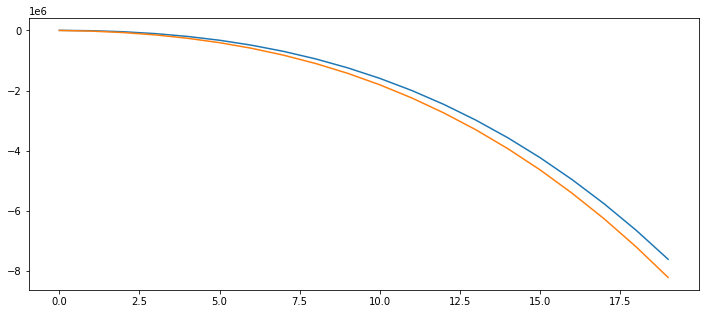

In [96]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

# Another copied code

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = PositionalEmbedding(vocab_size=vocab_size, d_model=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
maxlen = 128
vocab_size = tokenizers.en.get_vocab_size()
embed_dim = 512  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 256  # Hidden layer size in feed forward network inside transformer

inputs = tf.keras.layers.Input(shape=(maxlen,))
embedding_layer = PositionalEmbedding(vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
new_features

<tf.Tensor: shape=(43012, 128), dtype=int64, numpy=
array([[   2,   54, 3562, ...,    0,    0,    0],
       [   2,   81,   80, ...,    0,    0,    0],
       [   2,   55,  631, ...,    0,    0,    0],
       ...,
       [   2,   76,    9, ...,    0,    0,    0],
       [   2,   81,   80, ...,    0,    0,    0],
       [   2, 1186, 2367, ...,    0,    0,    0]])>

In [ ]:
labels.shape

(43012,)

In [ ]:
history = model.fit(
    new_features, labels, batch_size=32, epochs=4, validation_split=0.2
)

Epoch 1/4
1076/1076 [==============================] - 40s 32ms/step - loss: 0.6947 - accuracy: 0.5210 - val_loss: 0.6928 - val_accuracy: 0.5137
Epoch 2/4
1076/1076 [==============================] - 34s 32ms/step - loss: 0.6923 - accuracy: 0.5213 - val_loss: 0.6929 - val_accuracy: 0.5137
Epoch 3/4
1076/1076 [==============================] - 35s 33ms/step - loss: 0.6924 - accuracy: 0.5213 - val_loss: 0.6929 - val_accuracy: 0.5137
Epoch 4/4
1076/1076 [==============================] - 35s 32ms/step - loss: 0.6923 - accuracy: 0.5213 - val_loss: 0.6929 - val_accuracy: 0.5137


In [ ]:
# model is shit

In [ ]:
df = pd.read_csv(val_data_loc)
df

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [ ]:
df = df[df.columns[2:]]

In [ ]:
df = df.rename(columns={"Irrelevant":"Sentiment", "I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣":"sentence"})
df

,Sentiment,sentence
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.


In [ ]:
df = df[df.apply(lambda x: (x["Sentiment"] == "Positive") or (x["Sentiment"] == "Negative"), axis=1)]

In [ ]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: index_helper(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.isna().value_counts()

Sentiment  sentence
False      False       543
dtype: int64

In [ ]:
labels = df['Sentiment']
features = df['sentence']

In [ ]:
test_features = prepare_batch(features)
test_features = test_features.to_tensor()
test_features

<tf.Tensor: shape=(543, 128), dtype=int64, numpy=
array([[   2,   31, 5759, ...,    0,    0,    0],
       [   2,   39,   88, ...,    0,    0,    0],
       [   2, 2265,   31, ...,    0,    0,    0],
       ...,
       [   2,  205,   92, ...,    0,    0,    0],
       [   2,  208,   55, ...,    0,    0,    0],
       [   2, 2013,   37, ...,    0,    0,    0]])>

In [ ]:
results = model.evaluate(x=test_features, y=labels)

17/17 [==============================] - 0s 17ms/step - loss: 0.6950 - accuracy: 0.4899


In [ ]:
tokenizers.en.detokenize(test_features[:3].numpy())

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'@ microsoft why do i pay for word when it functions so poorly on my @ samsungus chromebook ? [UNK]',
       b"csgo matchmaking is so full of closet hacking , it ' s a truly awful game .",
       b'hi @ eahelp i \xe2\x80\x99 ve had madeleine mccann in my cellar for the past 13 years and the little sneaky thing just escaped whilst i was loading up some fifa points , she took my card and i \xe2\x80\x99 m having to use my paypal account but it isn \xe2\x80\x99 t working , can you help me resolve it please ?'],
      dtype=object)>

In [ ]:
model(test_features[:3])

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.52231073, 0.47768924],
       [0.52231073, 0.47768924],
       [0.52231073, 0.47768924]], dtype=float32)>